# Class Activation Maps (CAM)

In [ ]:
# Imports
from email import utils
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch

import glob

# Change sys path to import from parent directory
import sys
sys.path.append('../')

from utils.datasets import ImageDataset

# Load model and dataset

In [15]:
# Download the model using torch hub
model = torch.hub.load('conorosully/XAI-for-CV-models', 'pot_plant_classifier_gap')

# Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)
model.eval()
model.zero_grad()

Using cache found in /Users/conorosullivan/.cache/torch/hub/conorosully_XAI-for-CV-models_main


In [3]:
base_path = "../../data/pot_plants/"

plant_names = ['rudo','baya','greg','yuki']
num_classes = len(plant_names)

# Load the data
test_paths = glob.glob(base_path + "/test/*.jpg")
test_data = ImageDataset(test_paths,num_classes)

(-0.5, 255.5, 255.5, -0.5)

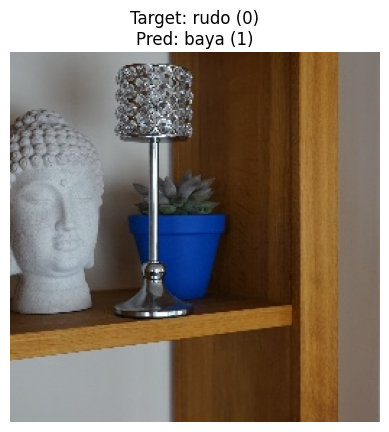

In [4]:
# Get random instance
image, target = test_data.__getitem__(3) # i = 10, 3

# Format input
input = image.unsqueeze(0).to(device)

# Format target
target = torch.argmax(target).item()
target_name = plant_names[target]

# Get the prediction
output = model(input)
pred = torch.argmax(output).item()
pred_name = plant_names[pred]

# Diplay prediction
rgb_image = image.permute(1,2,0).numpy ()
plt.imshow(rgb_image)
plt.title(f"Target: {target_name} ({target})\nPred: {pred_name} ({pred})")
plt.axis('off')

## Generate CAMs

In [5]:
# Get weights that connect GAP layer to output for class 1
gap_weights = model.fc[1].weight[1]

gap_weights.shape # [64]

torch.Size([64])

In [6]:
# Get final conv layer
final_conv_layer = model.conv_layers[-2]

# Hook to get the feature map from the last conv layer
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

hook_handle = final_conv_layer.register_forward_hook(hook_fn)

# Forward pass to get feature maps
model(input)

# Remove the hook
hook_handle.remove()

feature_maps[0].shape # [1, 64, 256, 256]

torch.Size([1, 64, 256, 256])

In [7]:
# Extract feature maps and GAP weights
feature_maps = feature_maps[0].squeeze(0).detach().cpu().numpy()  # Shape: [C, H, W]
gap_weights = gap_weights.detach().cpu().numpy()  # Shape: [C]

# Compute the CAM
cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)  # Shape: [H, W]
for i, w in enumerate(gap_weights):
    cam += w * feature_maps[i]

In [8]:
# ReLU on CAM (optional for better visualization)
cam = np.maximum(cam, 0)

# Normalize CAM for visualization
cam = cam - np.min(cam)
cam = cam / np.max(cam)

Figure saved to /Users/conorosullivan/Documents/XAI/CAM_heatmap.pdf


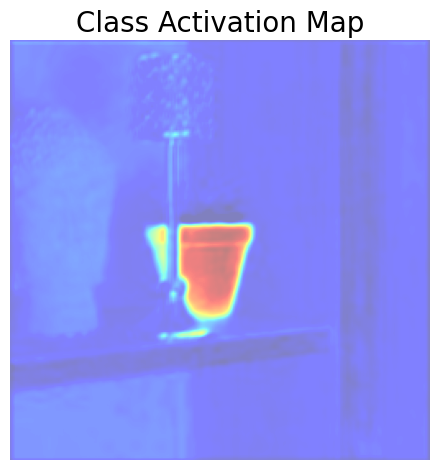

In [9]:
# Output class activation map
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Class Activation Map")
plt.axis("off")

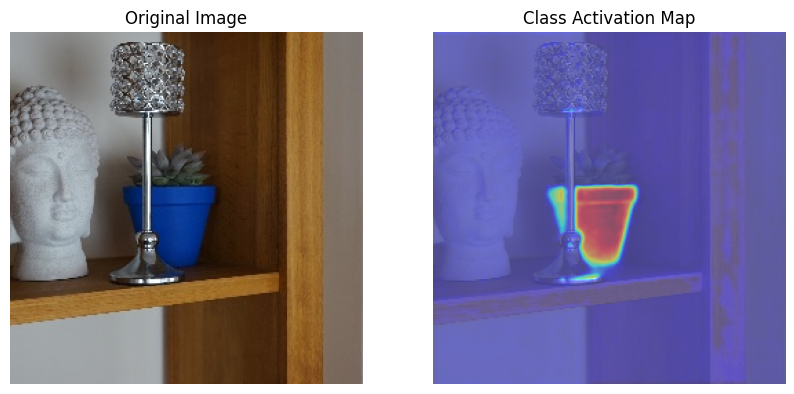

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Function to generate CAM
def generate_cam(model, input_image, class_idx):
    """
    Generate Class Activation Map (CAM) for a given input image and class index.

    Args:
    - model (nn.Module): The trained CNN model with GAP.
    - input_image (torch.Tensor): Input image tensor of shape [1, C, H, W].
    - class_idx (int): Index of the class for which CAM is to be generated.

    Returns:
    - cam (np.array): The generated CAM of shape [H, W].
    """
    # Get the final convolutional layer and the GAP weights
    final_conv_layer = model.conv_layers[-1]  # Last convolutional layer
    gap_weights = model.fc[1].weight[class_idx]  # Weights for the class in GAP layer

    # Hook to get the feature map from the last conv layer
    feature_maps = []

    def hook_fn(module, input, output):
        feature_maps.append(output)

    hook_handle = final_conv_layer.register_forward_hook(hook_fn)

    # Forward pass to get feature maps
    model(input_image)

    # Remove the hook
    hook_handle.remove()

    # Extract feature maps and GAP weights
    feature_maps = feature_maps[0].squeeze(0).detach().cpu().numpy()  # Shape: [C, H, W]
    gap_weights = gap_weights.detach().cpu().numpy()  # Shape: [C]

    # Compute the CAM
    cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)  # Shape: [H, W]
    for i, w in enumerate(gap_weights):
        cam += w * feature_maps[i]

    # ReLU on CAM (optional for better visualization)
    cam = np.maximum(cam, 0)

    # Normalize CAM for visualization
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

# Generate CAM for the predicted class
class_idx = pred  # Index of the predicted class
cam = generate_cam(model, input, class_idx)

# Plot the CAM on the original image
original_image = image.permute(1, 2, 0).detach().cpu().numpy()  # Convert to [H, W, C] format
original_image = (original_image - np.min(original_image)) / (np.max(original_image) - np.min(original_image))  # Normalize

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original_image, alpha=0.5)
plt.imshow(cam, cmap="jet", alpha=0.5)  # Overlay CAM on the image
plt.title("Class Activation Map")
plt.axis("off")

plt.show()